In [1]:
#from scipy import stats
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
#from scipy.optimize import curve_fit
#%matplotlib inline
# Suppress warnings. Comment this out if you wish to see the warning messages
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from tqdm import tqdm
import corner
import emcee

(80703, 20)


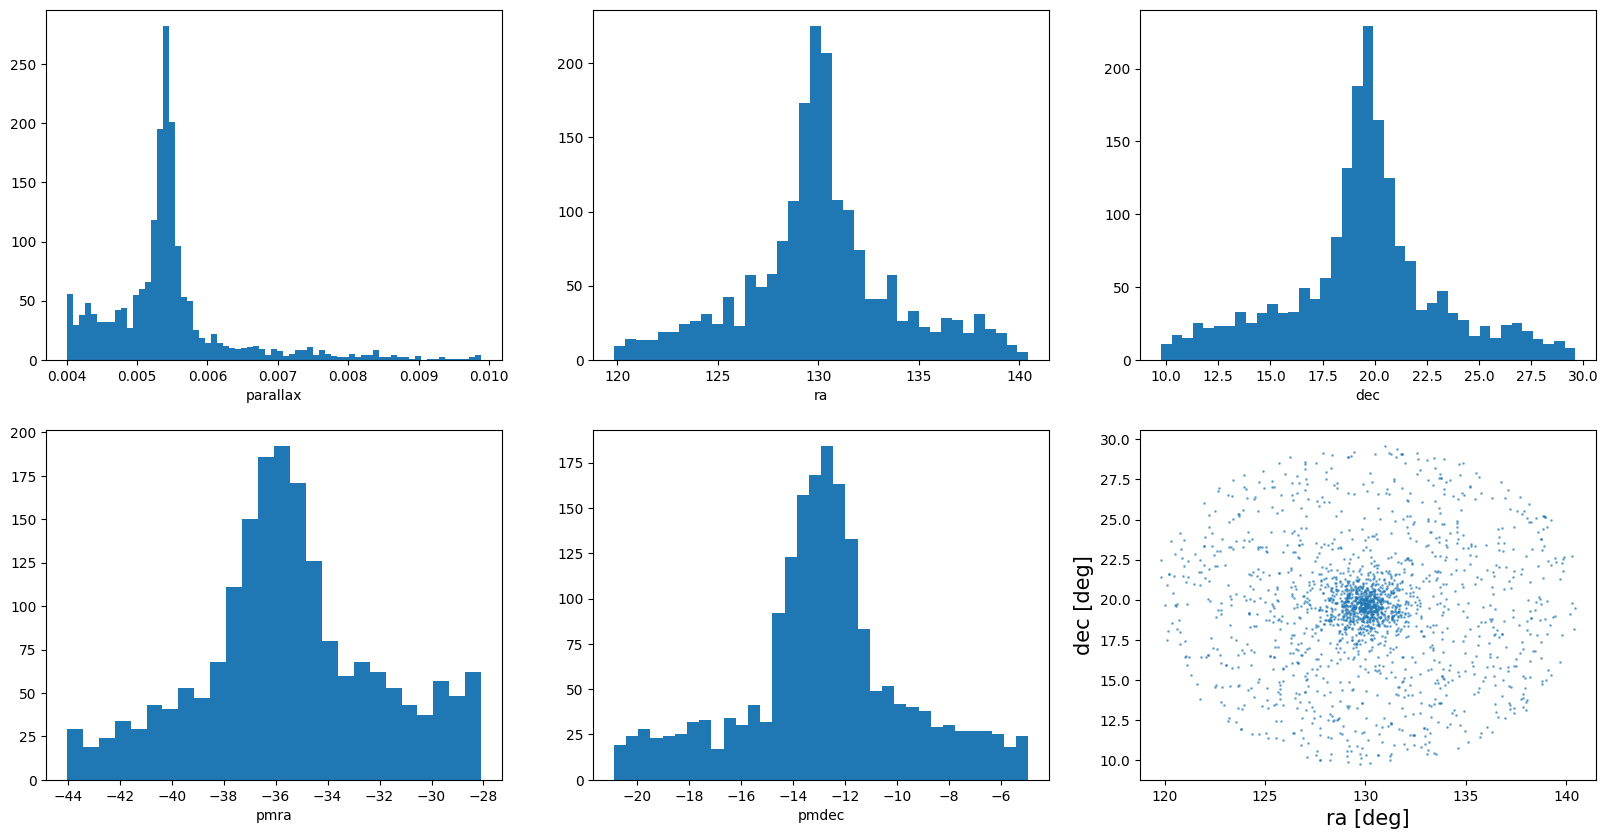

1893


In [2]:
df = pd.read_csv('./beehive_10.csv')
#df.loc[df['ra'] > 300, 'ra'] -= 360 #SOLO PARA BLANCO 1
df = df.fillna(0)
df['parallax'] = df['parallax'] / 1000
df['parallax_error'] = df['parallax_error'] / 1000
print(df.shape)

mu_alpha, mu_delta = -36.047, -12.917
rango = 8
c_pm=(df['pmra'] > mu_alpha - rango) & (df['pmra'] < mu_alpha + rango) & \
                        (df['pmdec'] > mu_delta - rango) & (df['pmdec'] < mu_delta + rango)
c_p = (df['parallax'] > 0.004) & (df['parallax'] < 0.01)

df = df[c_pm & c_p]

plt.figure(figsize=(20,10))

plt.subplot(2,3,1)
plt.hist(df.parallax,bins='auto')
plt.xlabel('parallax')

plt.subplot(2,3,2)
plt.hist(df.ra,bins='auto')
plt.xlabel('ra')

plt.subplot(2,3,3)
plt.hist(df.dec,bins='auto')
plt.xlabel('dec')

plt.subplot(2,3,4)
plt.hist(df.pmra,bins='auto')
#plt.xlim(-100,100)
plt.xlabel('pmra')

plt.subplot(2,3,5)
plt.hist(df.pmdec,bins='auto')
#plt.xlim(-100,100)
plt.xlabel('pmdec')

plt.subplot(2,3,6)
plt.scatter(df['ra'], df['dec'], marker='o' , s=1, alpha = 0.5)
plt.xlabel("ra [deg]",  fontsize = 15)
plt.ylabel("dec [deg]",  fontsize = 15)#,rotation=0)
#plt.xlim(-30,0)
#plt.ylim(0,30)
plt.show()

print(len(df))

In [3]:
def gaussian_function(x, params):
    nc, sc, sf, mu_c, mu_f = params
    Ac = -0.5*((x - mu_c)/sc)**2
    Be = -0.5*((x - mu_f)/sf)**2
    return nc/(np.sqrt(2*np.pi)*sc)*np.exp(Ac) + (1-nc)/(np.sqrt(2*np.pi)*sf)*np.exp(Be)

def log_likelihood(params, x):
    nc, sc, sf, mu_c, mu_f = params
    Ac = -0.5*((x - mu_c)/sc)**2
    Be = -0.5*((x - mu_f)/sf)**2
    y = nc/(np.sqrt(2*np.pi)*sc)*np.exp(Ac) + (1-nc)/(np.sqrt(2*np.pi)*sf)*np.exp(Be)
    # Calculate log likelihood
    return np.sum(np.log(y))

def log_prior(params):
    nc, sc, sf, mu_c, mu_f = params
    if 0.0 < nc < 1.0 and 0.0 < sc < 10.0 and 0.0 < sf < 10.0:
        return 0.0
    return -np.inf

def log_probability(params, x):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x)

nll = lambda *args: -log_likelihood(*args)

In [4]:
sample_data = df.pmra
sc, sf = np.std(sample_data)/2, np.std(sample_data)
mu_c, mu_f = np.mean(sample_data), np.mean(sample_data)
initparams_pmra = [0.5, sc, sf, mu_c, mu_f]
print(log_likelihood(initparams_pmra, sample_data))
print(log_prior(initparams_pmra))
print(log_probability(initparams_pmra, sample_data))

results_pmra = minimize(nll, initparams_pmra, args=(sample_data), options={"disc":True}, method='Nelder-Mead')
results_pmra.x

-5139.723127083209
0.0
-5139.723127083209


array([  0.22115376,   0.87281115,   3.93922786, -35.99260613,
       -35.36842134])

In [5]:
sample_data = df.pmdec
sc, sf = np.std(sample_data)/2, np.std(sample_data)
mu_c, mu_f = np.mean(sample_data), np.mean(sample_data)
initparams_pmdec = [0.5, sc, sf, mu_c, mu_f]
print(log_likelihood(initparams_pmdec, sample_data))
print(log_prior(initparams_pmdec))
print(log_probability(initparams_pmdec, sample_data))

results_pmdec = minimize(nll, initparams_pmdec, args=(sample_data), options={"disc":True}, method='Nelder-Mead')
results_pmdec.x

-4909.549560050082
0.0
-4909.549560050082


array([  0.34087998,   0.90488743,   3.92582596, -12.87465234,
       -12.75674254])

Text(0.5, 0, 'pmdec')

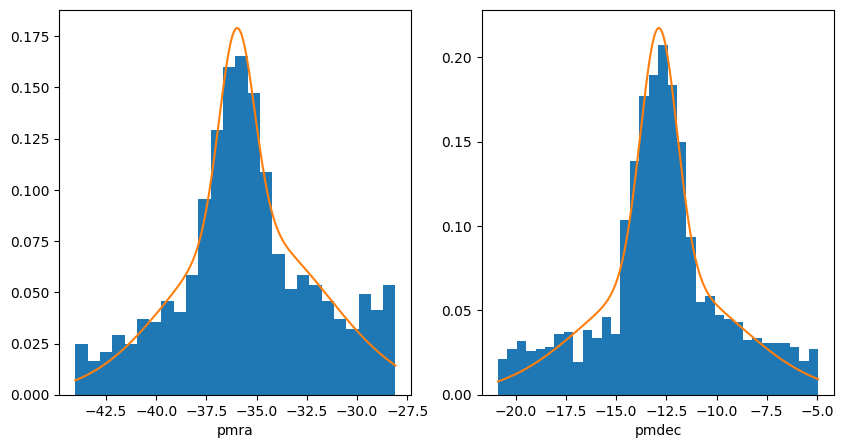

In [6]:
plt.figure(figsize=(10,5))
sample_data = df.pmra
plt.subplot(1,2,1)
bin_heights, bin_borders, _ = plt.hist(sample_data, bins='auto',
                                       range=(min(sample_data),max(sample_data)),density=True)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
x = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x, gaussian_function(x, results_pmra.x))
plt.xlabel('pmra')

plt.subplot(1,2,2)
sample_data = df.pmdec
bin_heights, bin_borders, _ = plt.hist(sample_data, bins='auto',
                                       range=(min(sample_data),max(sample_data)),density=True)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
x = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x, gaussian_function(x, results_pmdec.x))
plt.xlabel('pmdec')

In [7]:
sample_data = df.pmra
n_walkers, n_dim = 250, 5
p0 = results_pmra.x + 1e-4 * np.random.randn(n_walkers, n_dim)

sampler_pmra = emcee.EnsembleSampler(n_walkers, n_dim, log_probability, args=[sample_data])
pos, prob, state = sampler_pmra.run_mcmc(p0, 500, progress = True)

100%|█████████████████████████████████████████| 500/500 [02:02<00:00,  4.07it/s]


Text(0.5, 0, 'step number')

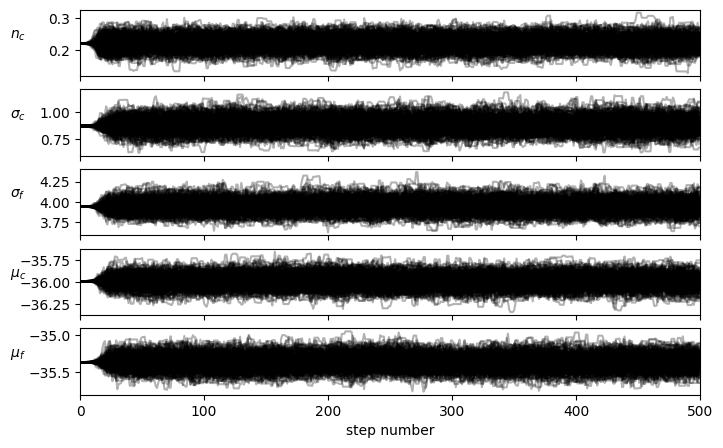

In [8]:
fig, axes = plt.subplots(n_dim, figsize=(8, 5), sharex=True)
samples = sampler_pmra.get_chain()
labels = ["$n_c$", "$\sigma_c$", "$\sigma_f$", "$\mu_c$", "$\mu_f$"]
for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

Minimize: [  0.22115376   0.87281115   3.93922786 -35.99260613 -35.36842134]
MCMC:     [  0.22018597   0.88091434   3.94150978 -35.9922247  -35.36433139]
(6500, 5)


<Figure size 800x800 with 0 Axes>

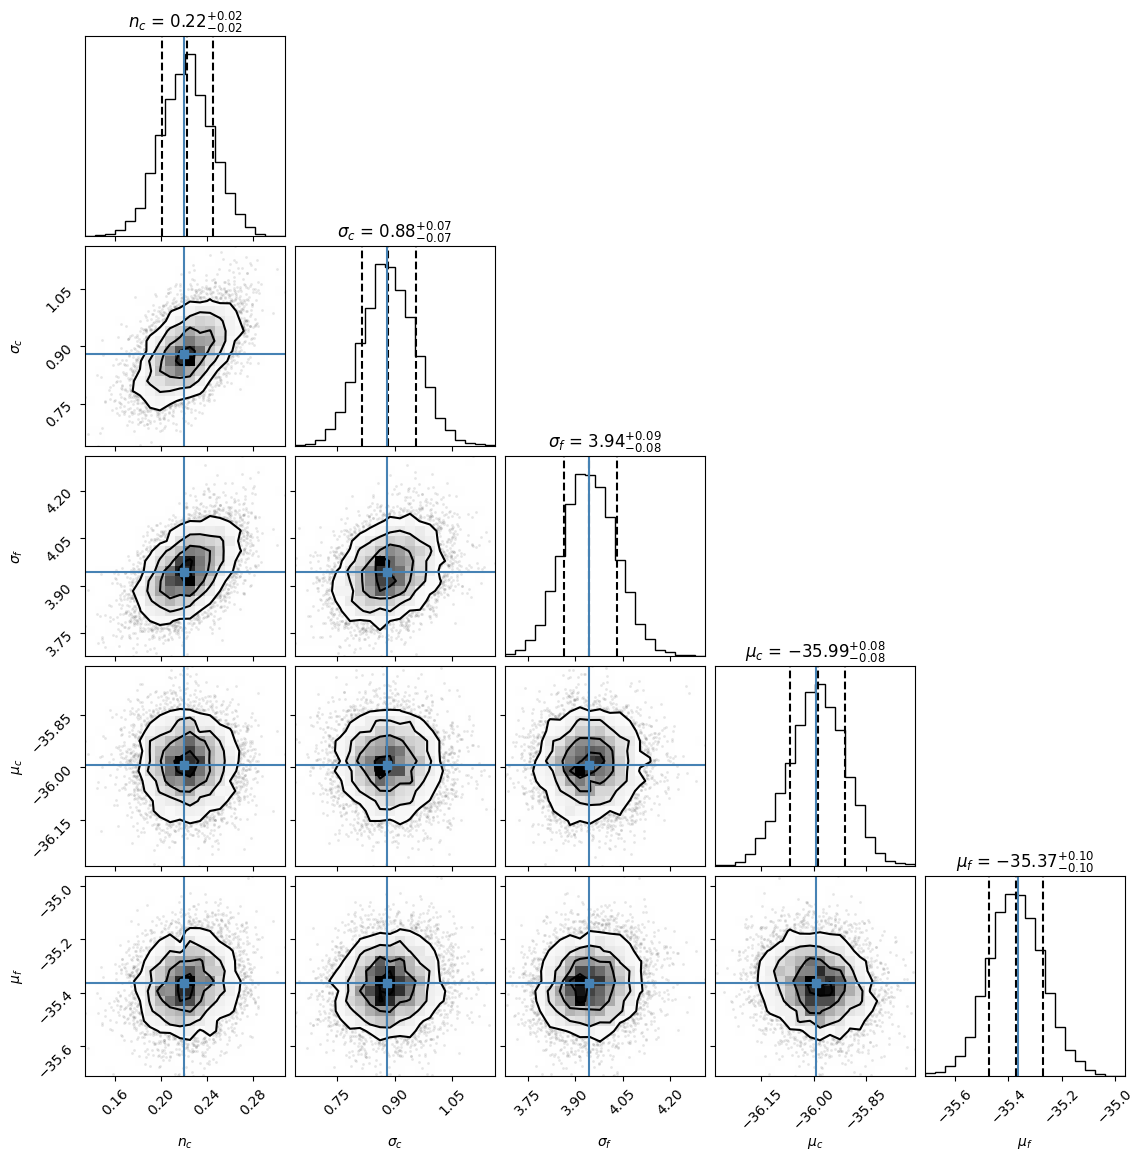

In [9]:
#tau = sampler.get_autocorr_time()
#print(tau)

params_mcmc_pmra = np.percentile(pos ,50, axis=0)
print('Minimize:',results_pmra.x)
print('MCMC:    ',params_mcmc_pmra)

flat_samples = sampler_pmra.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

truths = params_mcmc_pmra
plt.figure(figsize=(8,8))
fig = corner.corner(flat_samples, labels=labels, truths=truths, quantiles=[0.16, 0.5, 0.84], show_titles=True,
                      title_kwargs={"fontsize": 12})

In [10]:
sample_data = df.pmdec
n_walkers, n_dim = 250, 5
p0 = results_pmdec.x + 1e-4 * np.random.randn(n_walkers, n_dim)

sampler_pmdec = emcee.EnsembleSampler(n_walkers, n_dim, log_probability, args=[sample_data])
pos, prob, state = sampler_pmdec.run_mcmc(p0, 500, progress = True)

100%|█████████████████████████████████████████| 500/500 [02:03<00:00,  4.05it/s]


Text(0.5, 0, 'step number')

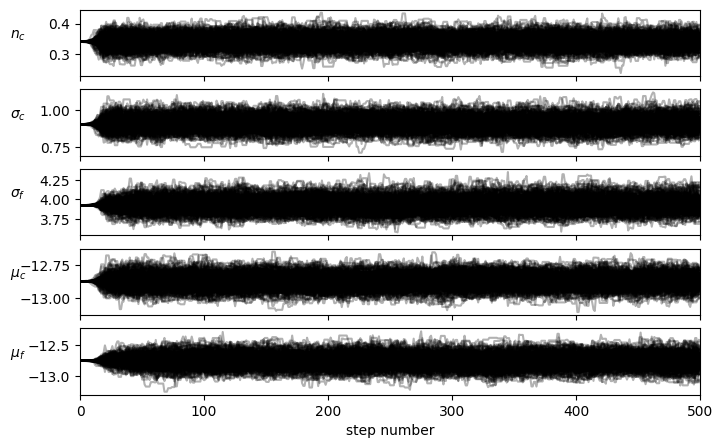

In [11]:
fig, axes = plt.subplots(n_dim, figsize=(8, 5), sharex=True)
samples = sampler_pmdec.get_chain()
labels = ["$n_c$", "$\sigma_c$", "$\sigma_f$", "$\mu_c$", "$\mu_f$"]
for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

Minimize: [  0.34087998   0.90488743   3.92582596 -12.87465234 -12.75674254]
MCMC:     [  0.34061961   0.90685966   3.93348305 -12.8772392  -12.75250152]
(6500, 5)


<Figure size 800x800 with 0 Axes>

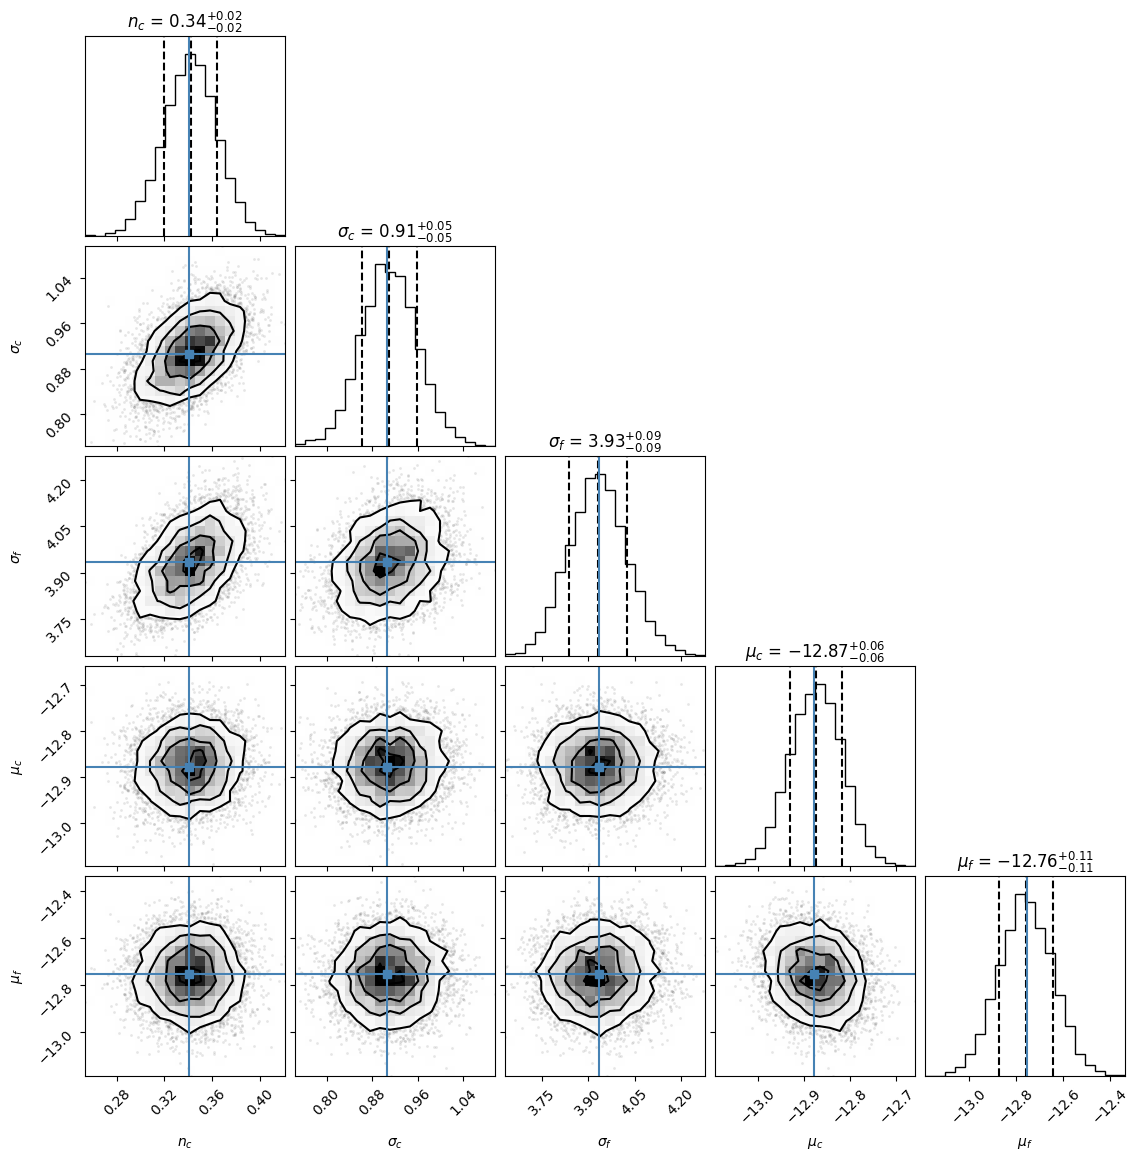

In [12]:
#tau = sampler.get_autocorr_time()
#print(tau)

params_mcmc_pmdec = np.percentile(pos ,50, axis=0)
print('Minimize:',results_pmdec.x)
print('MCMC:    ',params_mcmc_pmdec)

flat_samples = sampler_pmdec.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

truths = params_mcmc_pmdec
plt.figure(figsize=(8,8))
fig = corner.corner(flat_samples, labels=labels, truths=truths, quantiles=[0.16, 0.5, 0.84], show_titles=True,
                      title_kwargs={"fontsize": 12})

Text(0.5, 0, 'pmdec')

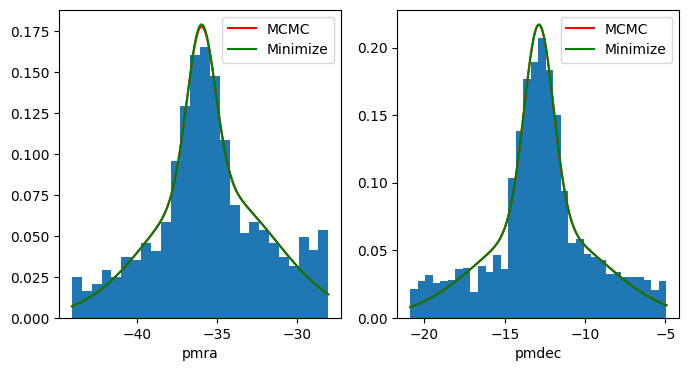

In [13]:
sample_data = df.pmra
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
bin_heights, bin_borders, _ = plt.hist(sample_data, bins='auto',
                                       range=(min(sample_data),max(sample_data)),density=True)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
x = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x, gaussian_function(x, params_mcmc_pmra), label='MCMC',color='red')
plt.plot(x, gaussian_function(x, results_pmra.x), label='Minimize', color='green')
plt.legend()
plt.xlabel('pmra')

plt.subplot(1,2,2)
sample_data = df.pmdec
bin_heights, bin_borders, _ = plt.hist(sample_data, bins='auto',
                                       range=(min(sample_data),max(sample_data)),density=True)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
x = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x, gaussian_function(x, params_mcmc_pmdec), label='MCMC',color='red')
plt.plot(x, gaussian_function(x, results_pmdec.x), label='Minimize',color='green')
plt.legend()
plt.xlabel('pmdec')

In [14]:
def log_prior(params):
    nc, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf = params
    if 0.0 < nc < 1.0 and 0.0 < s < 10.0 and 0.0 < sx < 10.0 and 0.0 < sy < 10.0 and -1.0 < rho < 1.0:
        return 0.0
    return -np.inf

def log_likelihood(params, x, y):
    nc, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf = params
    amp_circ = nc / (2 * np.pi * s**2)
    amp_elip = (1-nc) / (2 * np.pi * sx * sy * np.sqrt(1 - rho**2))
    Exp_circ = -0.5 * (((x - mu_xc)/s)**2 + ((y - mu_yc)/s)**2)
    Exp_elip = -1/(2*(1-rho**2))*(((x - mu_xf)/sx)**2+((y - mu_yf)/sy)**2-2*rho*((x - mu_xf)/sx)*((y - mu_yf)/sy))
    z = amp_circ * np.exp(Exp_circ) + amp_elip * np.exp(Exp_elip)
    # Calculate log likelihood
    return np.sum(np.log(z))

def log_probability(params, x, y):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x, y)

In [15]:
x = df.pmra
y = df.pmdec
#nc, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf
rho_matrix = np.corrcoef(df.pmra, df.pmdec)
initparams = [0.5, results_pmra.x[1], results_pmra.x[2], results_pmdec.x[2], rho_matrix[0][1],
       results_pmra.x[3], results_pmdec.x[3], results_pmra.x[4], results_pmdec.x[4]]
print(initparams)
print(log_likelihood(initparams, x, y))
print(log_prior(initparams))
print(log_probability(initparams, x, y))

nll = lambda *args: -log_likelihood(*args)

results = minimize(nll, initparams, args=(x, y), options={"disc":True}, method='Nelder-Mead')
results.x

[0.5, 0.8728111473865305, 3.9392278568032992, 3.9258259574792103, 0.09619148814303108, -35.99260613407059, -12.874652338504744, -35.36842134377264, -12.756742542363725]
-9650.850143196772
0.0
-9650.850143196772


array([  0.34635535,   0.96613594,   4.25737434,   3.94115491,
         0.09760613, -35.96826931, -12.85916924, -35.26174904,
       -12.76398261])

In [16]:
x = df.pmra
y = df.pmdec
#nc, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf

n_walkers, n_dim = 250, 9
p0 = results.x + 1e-4 * np.random.randn(n_walkers, n_dim)

sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_probability, args=[x, y])
pos, prob, state = sampler.run_mcmc(p0, 5000, progress = True)

100%|███████████████████████████████████████| 5000/5000 [37:43<00:00,  2.21it/s]


Text(0.5, 0, 'step number')

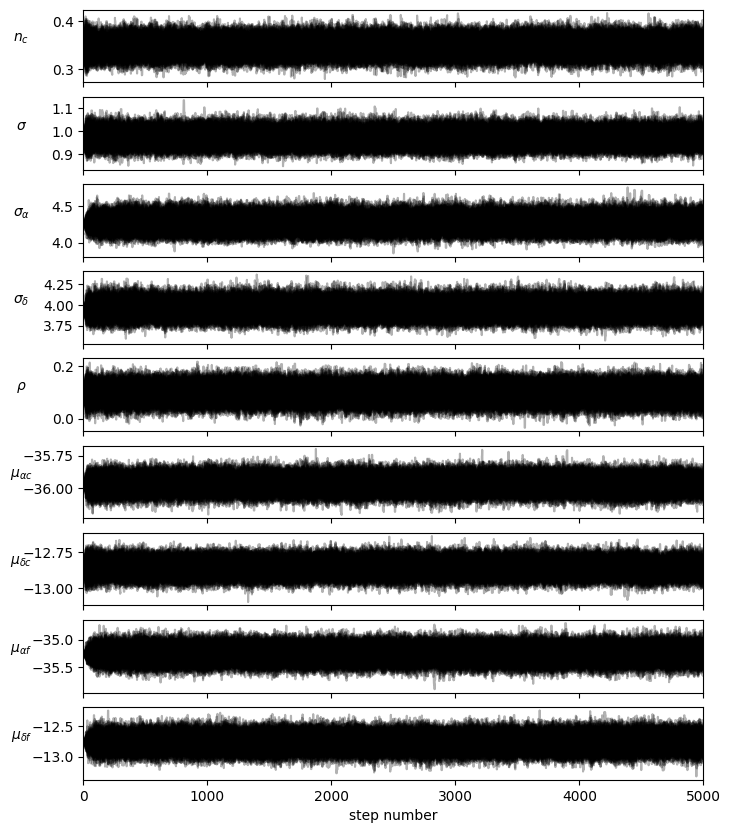

In [17]:
fig, axes = plt.subplots(n_dim, figsize=(8, 10), sharex=True)
samples = sampler.get_chain()
labels = ["$n_c$", "$\sigma$", "$\sigma_{\\alpha}$", "$\sigma_{\delta}$", "$\\rho$",
          "$\mu_{\\alpha c}$", "$\mu_{\delta c}$", "$\mu_{\\alpha f}$", "$\mu_{\delta f}$"]
for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i], rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

Minimize: [  0.34635535   0.96613594   4.25737434   3.94115491   0.09760613
 -35.96826931 -12.85916924 -35.26174904 -12.76398261]
MCMC:     [  0.34179368   0.97836958   4.25607426   3.92709093   0.11902007
 -35.97068815 -12.88292401 -35.22924809 -12.73840628]
(81500, 9)


<Figure size 800x800 with 0 Axes>

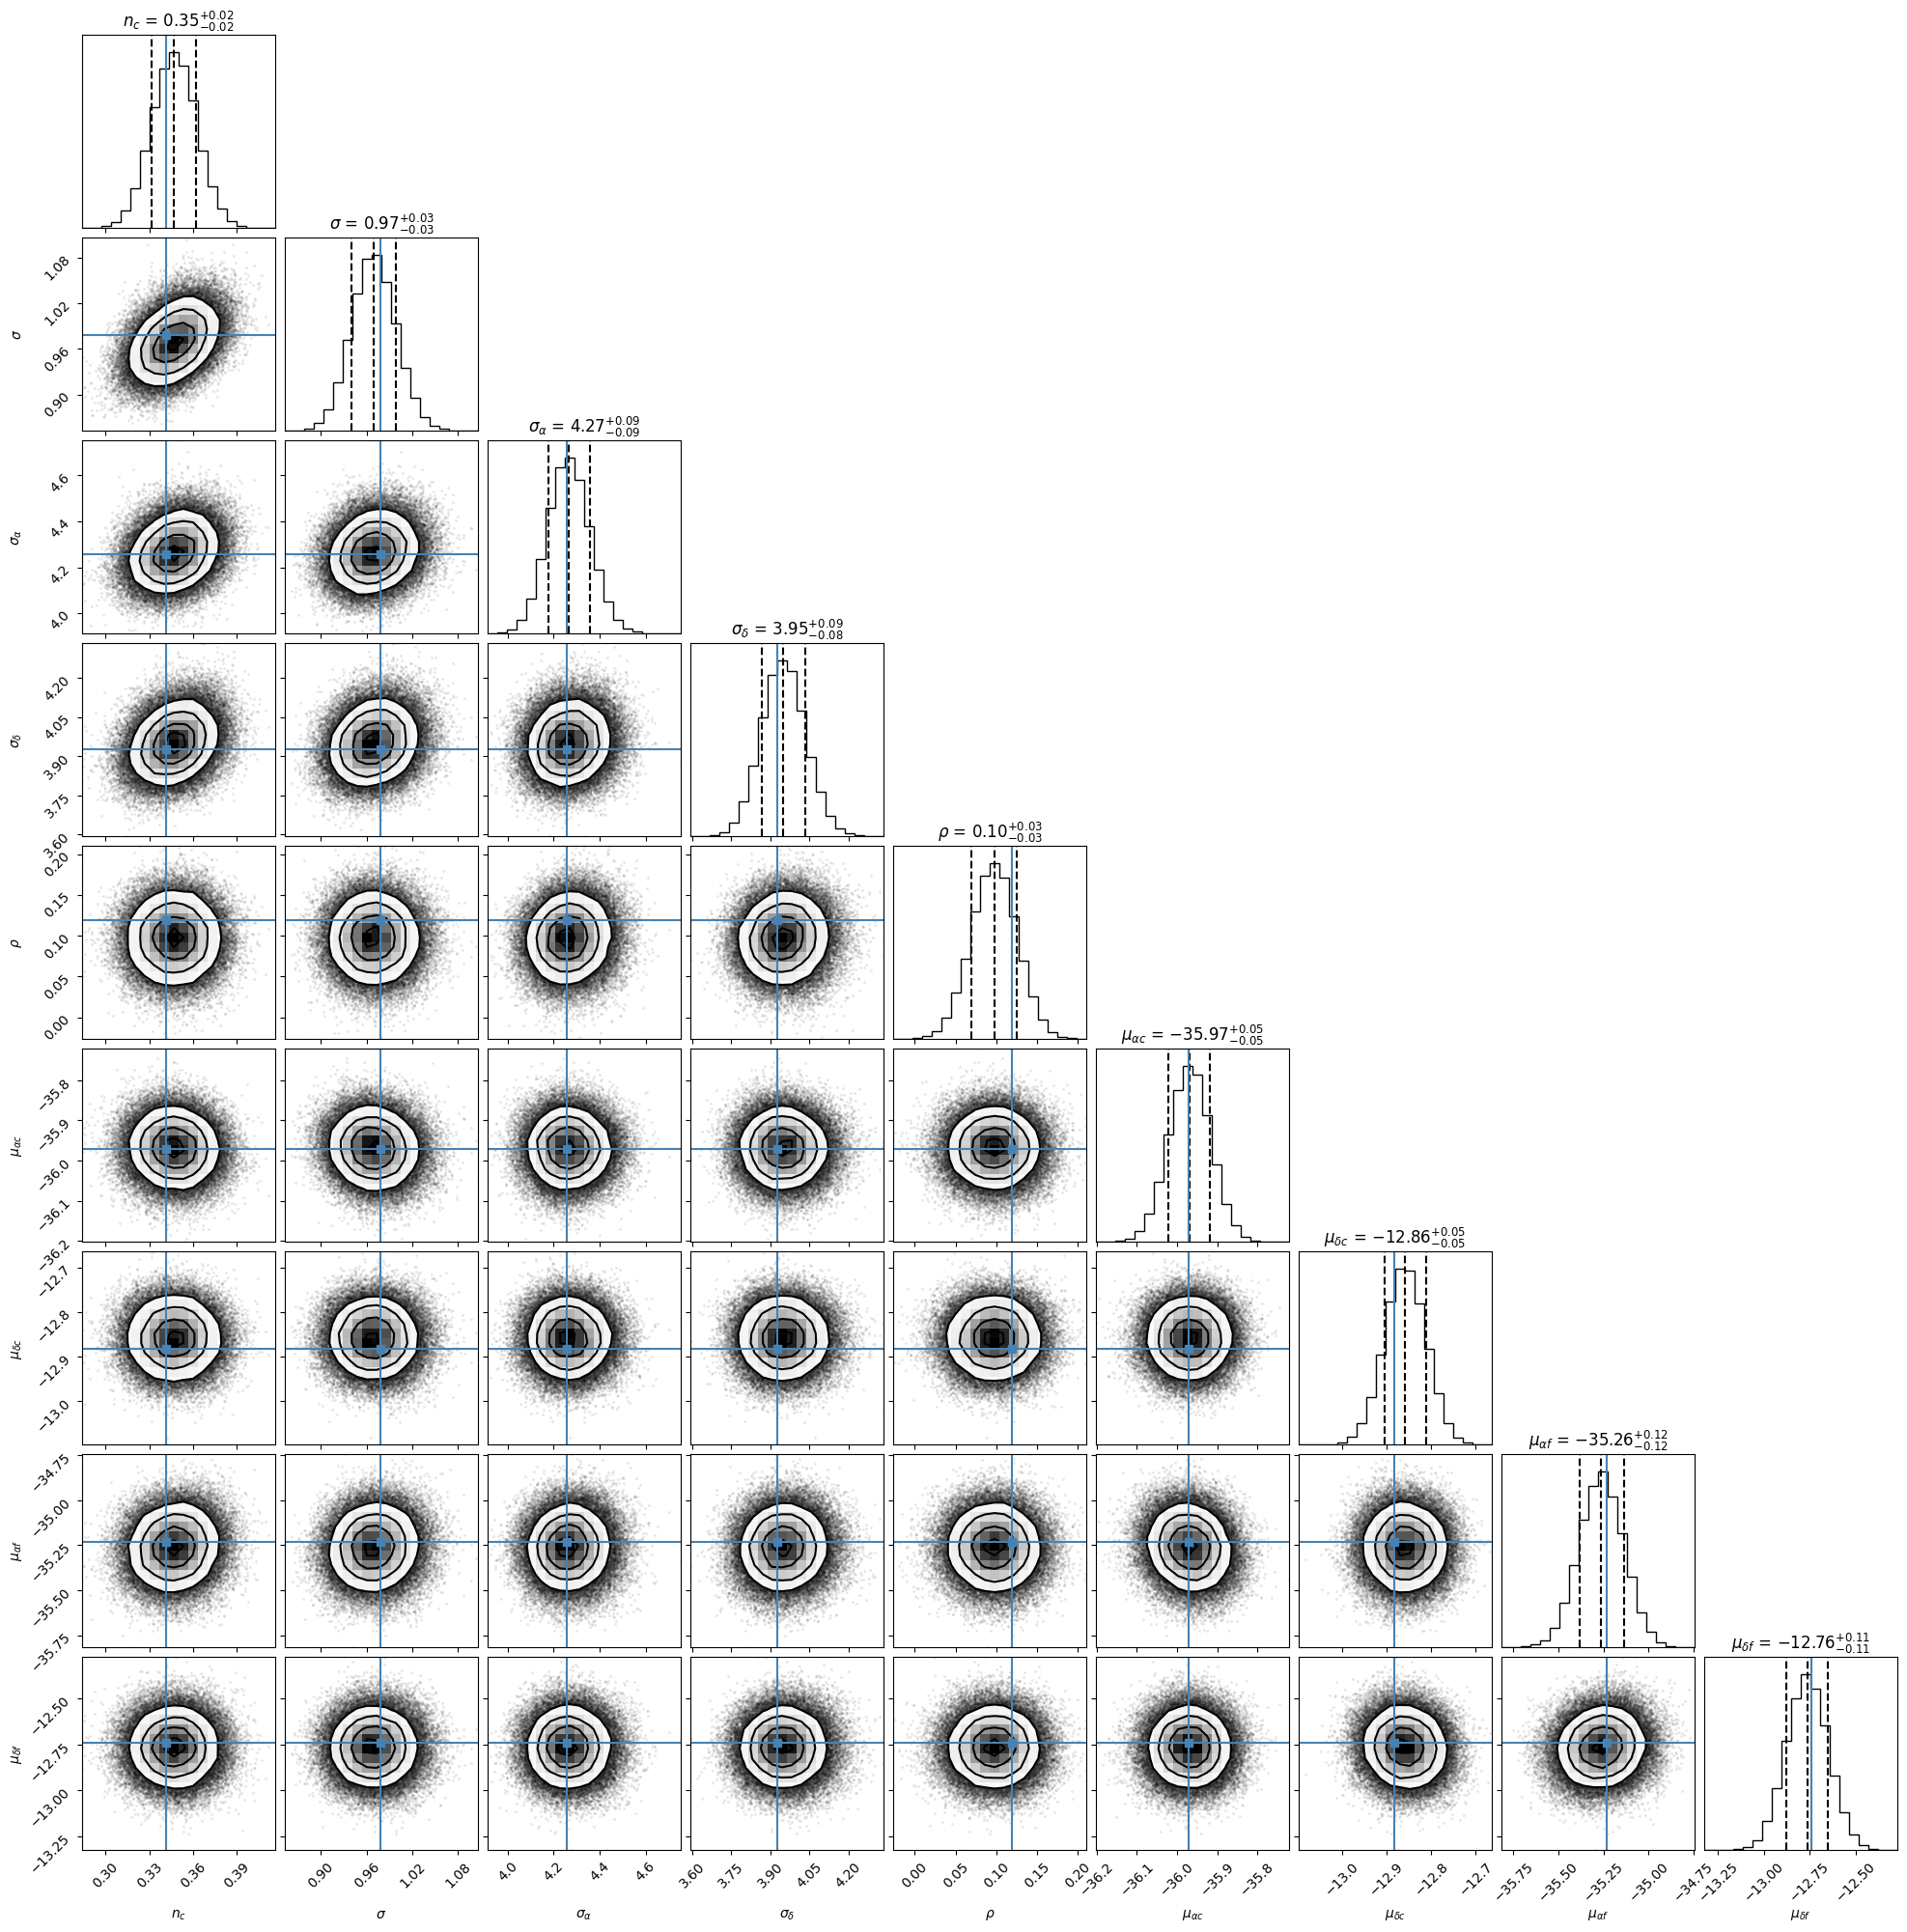

In [19]:
#params_mcmc = np.percentile(pos ,50, axis=0)
maxprob_indice = np.argmax(prob)
params_mcmc = pos[maxprob_indice]

print('Minimize:',results.x)
print('MCMC:    ',params_mcmc)

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)
truths = params_mcmc

plt.figure(figsize=(8,8))
fig = corner.corner(flat_samples, labels=labels, truths=truths, quantiles=[0.16, 0.5, 0.84], show_titles=True,
                      title_kwargs={"fontsize": 12})
#plt.savefig('./corner.png',bbox_inches = "tight")

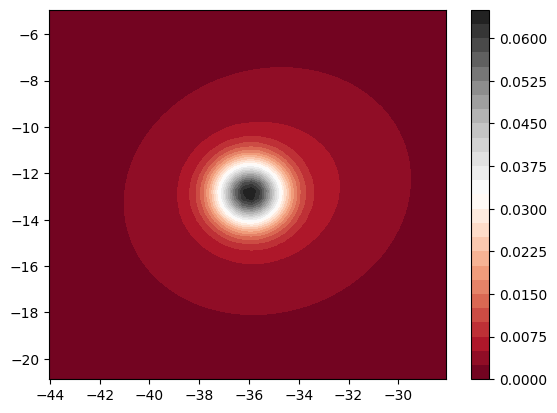

In [20]:
x = np.linspace(min(df.pmra), max(df.pmra), 50)
y = np.linspace(min(df.pmdec), max(df.pmdec), 50)

def func(x, y, params):
    nc, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf = params
    amp_circ = nc / (2 * np.pi * s**2)
    amp_elip = (1-nc) / (2 * np.pi * sx * sy * np.sqrt(1 - rho**2))
    Exp_circ = -0.5 * (((x - mu_xc)/s)**2 + ((y - mu_yc)/s)**2)
    Exp_elip = -1/(2*(1-rho**2))*(((x - mu_xf)/sx)**2+((y - mu_yf)/sy)**2-2*rho*((x - mu_xf)/sx)*((y - mu_yf)/sy))
    z = amp_circ * np.exp(Exp_circ) + amp_elip * np.exp(Exp_elip)
    return z

X, Y = np.meshgrid(x, y)
Z = func(X, Y, results.x)

plt.contourf(X, Y, Z, 30, cmap='RdGy')
plt.colorbar()
#plt.xlim(16,22)
#plt.ylim(0,5)

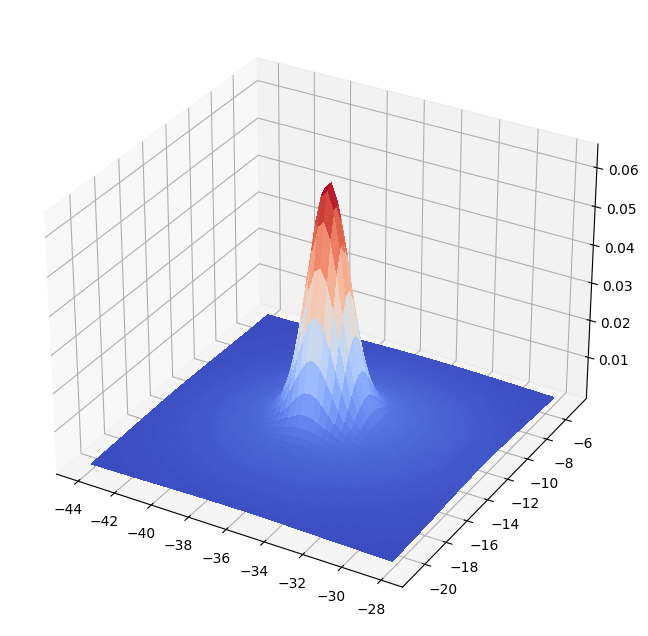

In [21]:
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(8, 8))
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)

0.9053977244182012


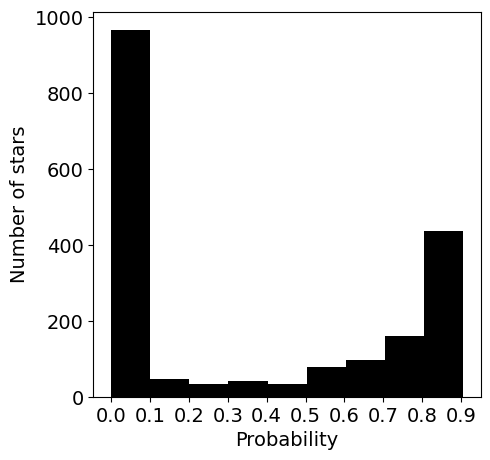

In [22]:
#nf, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf = truths
nc, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf = results.x

def probabilidad_circ(xy, nc, s, mu_xc, mu_yc):
    x, y = xy
    amp_circ =  1 / (2 * np.pi * s**2)
    Exp_circ = - 1/2 * (((x - mu_xc)/s)**2 + ((y - mu_yc)/s)**2)
    return nc * amp_circ * np.exp(Exp_circ)

def probabilidad_elip(xy, nc, sx, sy, rho, mu_xf, mu_yf):
    x, y = xy
    amp_elip = 1 / (2 * np.pi * sx * sy * np.sqrt(1 - rho**2))
    Exp_elip = - 1/(2*(1-rho**2))*(((x - mu_xf)/sx)**2+((y - mu_yf)/sy)**2-2*rho*((x - mu_xf)/sx)*((y - mu_yf)/sy))
    return (1-nc) * amp_elip * np.exp(Exp_elip)

xy = np.vstack((df.pmra, df.pmdec))
param_circ_prob = (nc, s, mu_xc, mu_yc)
param_elip_prob = (nc, sx, sy, rho, mu_xf, mu_yf)
p_circ = probabilidad_circ(xy, *param_circ_prob)
p_elip = probabilidad_elip(xy, *param_elip_prob)
prob = p_circ / (p_circ + p_elip)
#print('Min: {:.10f} Max: {:.10f}'.format(min(prob), max(prob)))
prob_limit = 0.5
members = (prob >= prob_limit)
no_members = (prob < prob_limit)
print(max(prob))
plt.figure(figsize=(5,5))
#plt.hist(prob, bins=5,range=[min(prob), 0.5], label='Field stars',color='gray')
#plt.hist(prob[(prob > 0.5)], bins=5,color='cyan',label='Cluster stars')
plt.hist(prob, bins=9,range=[min(prob), max(prob)],color='black')#histtype='step'
plt.xlabel('Probability',fontsize=14)
plt.ylabel('Number of stars',fontsize=14)
plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
#plt.axvline(x = 0.5, color = 'black', label = 'Cut off', linestyle = '--')
#plt.legend()
#plt.savefig('./results/pleiades_probabilities.jpg',bbox_inches = "tight")
plt.show()

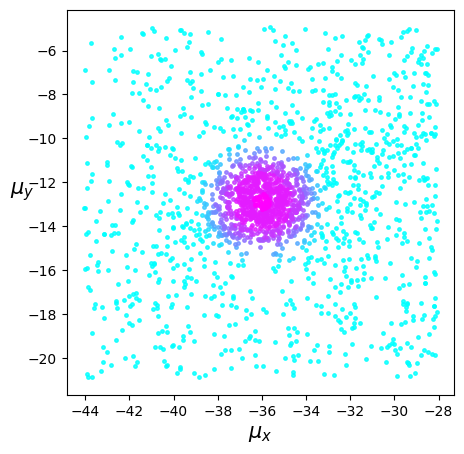

In [23]:
#colors=['black','dimgray','darkgrey','gainsboro','wheat','rosybrown','lightcoral','indianred','salmon','red']
#loop = np.arange(0.0, 1.0, 0.1)
loop = np.arange(0.0, 1.0, 0.1)
colors = [plt.cm.cool(each) for each in np.linspace(0, 1, len(loop))]

plt.figure(figsize=(5,5))
for i,c in zip(loop, colors):
  cond = (prob >= i) & (prob < i + 0.1)
  pmra_, pmdec_ = df.pmra[(cond)], df.pmdec[(cond)]
  plt.plot(pmra_, pmdec_,marker='.',c=c,linestyle='None',markersize=5,alpha=0.8)
plt.xlabel("$\mu_{x}$", fontsize = 15)
plt.ylabel("$\mu_{y}$", fontsize = 15,rotation=0)
#plt.savefig('./VPDClasses.jpg')
plt.show()

In [24]:
df['probability'] = prob
m44_members = df[members]
#m44_members.to_csv('./beehive_PMmodel.csv')
print(len(m44_members))
m44_members

774


,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,...,g,g_error,rp,rp_error,bp,bp_error,rv,rv_error,ruwe,probability
606,686562105793839488,134.871532,0.043838,23.227133,0.023411,0.004355,0.000056,-35.273022,0.053545,-12.589690,...,16.184465,3.030046,15.040220,13.612333,17.527868,8.736464,0.000000,0.000000,0.998989,0.875700
685,686585397400693760,134.549079,0.399526,23.515403,0.201602,0.005407,0.000484,-35.703967,0.461963,-14.650769,...,19.955772,0.656005,19.831284,6.251777,20.122845,6.580058,0.000000,0.000000,1.035697,0.647615
3106,687437003515673472,138.745317,0.160645,23.774139,0.112836,0.006111,0.000181,-36.062678,0.217768,-14.642174,...,17.994520,1.870739,16.758158,9.921955,19.667614,13.735422,0.000000,0.000000,1.076453,0.660407
3107,687437007811705728,138.743828,0.089147,23.770636,0.059810,0.005961,0.000105,-36.142683,0.120464,-14.643184,...,17.300758,2.200867,16.090551,17.375135,18.907928,9.084361,0.000000,0.000000,0.955390,0.658056
3956,687858636161318144,138.946341,0.257946,25.159136,0.202052,0.008070,0.000486,-35.661251,0.420309,-11.830592,...,18.514076,7.286453,16.011757,261.608920,17.202574,114.527230,0.000000,0.000000,0.969028,0.841160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75349,606157019476997760,137.850123,0.057177,13.315161,0.038971,0.005081,0.000073,-36.538219,0.075006,-13.550947,...,16.693779,2.432654,15.566793,10.198008,18.017006,8.100107,0.000000,0.000000,1.054601,0.867427
77638,604037985692543616,134.943616,0.106240,11.806051,0.074537,0.004430,0.000133,-37.487142,0.136639,-14.285852,...,17.911840,1.708225,16.650723,6.974502,19.665728,6.124672,0.000000,0.000000,0.974869,0.529062
78485,607223477036452608,135.671858,0.013686,14.459610,0.009129,0.005063,0.000018,-35.995965,0.019220,-12.467160,...,10.578259,158.733030,10.149335,139.395580,10.845507,174.069950,15.732321,0.226714,1.030258,0.898946
79335,610696452016191232,135.319609,0.083720,16.096254,0.053325,0.004310,0.000106,-36.652554,0.103892,-12.918784,...,17.414545,1.987303,16.224775,9.554013,18.958700,8.179525,0.000000,0.000000,0.979473,0.885928
